# Atrial Fibrillation Classification from a Short Single Lead ECG Recording

In [ ]:
import numpy as np
import os, datetime
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve,auc, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Set GPU memory growth on

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## Load the data and create training and validation datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

data_dir = "drive/MyDrive/AI_project/AI_dataset5"
data_dir = pathlib.Path(data_dir)

save_dir = "drive/MyDrive/AI_project/Models"
save_dir = pathlib.Path(save_dir)

logs_dir = "drive/MyDrive/AI_project/Logs"
logs_dir = pathlib.Path(data_dir)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# checking image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

16160


In [ ]:
# checking file names
file_names = os.listdir("/content/drive/My Drive/AI_project/AI_dataset5")
file_names


['Normal', 'AF', 'Noisy', 'Other']

In [ ]:
# define batch size and image size
batch_size = 32
img_width = 64
img_height = 256
classes = ['N', 'A', 'O', '~']

In [ ]:
# train / validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_width,img_height),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_width,img_height),
  batch_size=batch_size)


Found 16160 files belonging to 4 classes.
Using 12928 files for training.
Found 16160 files belonging to 4 classes.
Using 3232 files for validation.


In [ ]:
# check the labels
class_names_t = train_ds.class_names
print(class_names_t)

class_names_v = val_ds.class_names
print(class_names_v)

['AF', 'Noisy', 'Normal', 'Other']
['AF', 'Noisy', 'Normal', 'Other']


## Visualize training set scalograms

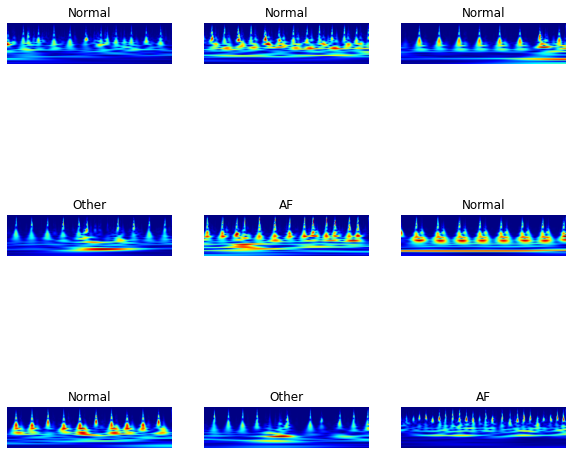

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_v[labels[i]])
    plt.axis("off")
plt.show()

## Setting cache autotune


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Defining layers

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

random_shift = tf.keras.layers.experimental.preprocessing.RandomTranslation(
    height_factor = (-0.02,0.02), width_factor = (-0.02,0.02), fill_mode='wrap',
    interpolation='bilinear', seed=None, name=None, 
    )


prediction_layer_1 = tf.keras.layers.Dense(2048,activation='relu')
prediction_layer_2 = tf.keras.layers.Dense(1024,activation='relu')
prediction_layer_3 = tf.keras.layers.Dense(512,activation='relu')
prediction_layer_4 = tf.keras.layers.Dense(4)

In [ ]:
def res_net_block(input_data, filters, conv_size):
  x = layers.Conv2D(filters, conv_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4))(input_data)
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, conv_size, activation=None, padding='same',kernel_regularizer=regularizers.l2(1e-4))(x)
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([x, input_data]) # skip connection
  x = layers.Activation('relu')(x)
  return x

## Define early stopping hook

In [ ]:
custom_early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                                      patience = 8, 
                                      min_delta = 0.01, 
                                      mode='max')

## Define the model

In [ ]:
# the model
IMG_SIZE = (64,256)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

inputs = tf.keras.Input(shape=IMG_SHAPE)

x = normalization_layer(inputs)

x = random_shift(x)

x = tf.keras.layers.Conv2D(32,(3,3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.SpatialDropout2D(0.3)(x)
x = layers.BatchNormalization()(x)

num_res_net_blocks = 0
for i in range(num_res_net_blocks):
    x = res_net_block(x, 32, 3)

x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64,(5,5), activation='relu',padding="same",kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.SpatialDropout2D(0.3)(x)
x = layers.BatchNormalization()(x)

num_res_net_blocks = 0
for i in range(num_res_net_blocks):
    x = res_net_block(x, 64, 5)

x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128,(9,9), activation='relu',padding="same",kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.SpatialDropout2D(0.3)(x)
x = layers.BatchNormalization()(x)

num_res_net_blocks = 0
for i in range(num_res_net_blocks):
    x = res_net_block(x, 128, 9)

x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = global_average_layer(x)

x = prediction_layer_1(x,training=True)
x = tf.keras.layers.Dropout(0.3)(x)

x = prediction_layer_2(x,training=True)
x = tf.keras.layers.Dropout(0.3)(x)

x = prediction_layer_3(x,training=True)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = prediction_layer_4(x, training=True)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001


model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

(64, 256, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 256, 3)]      0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 256, 3)        0         
_________________________________________________________________
random_translation (RandomTr (None, 64, 256, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 256, 32)       896       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 64, 256, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 256, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 32)

## Model training

In [ ]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(val_ds) 

101/101 [==============================] - 2237s 22s/step - loss: 1.3997 - accuracy: 0.2533


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[custom_early_stopping])

Epoch 1/100
404/404 [==============================] - 9771s 24s/step - loss: 1.3268 - accuracy: 0.3451 - val_loss: 1.7440 - val_accuracy: 0.2546
Epoch 2/100
404/404 [==============================] - 12s 29ms/step - loss: 1.2118 - accuracy: 0.4308 - val_loss: 1.0862 - val_accuracy: 0.5266
Epoch 3/100
404/404 [==============================] - 12s 29ms/step - loss: 1.1205 - accuracy: 0.5070 - val_loss: 1.0184 - val_accuracy: 0.5523
Epoch 4/100
404/404 [==============================] - 12s 29ms/step - loss: 1.0591 - accuracy: 0.5444 - val_loss: 0.9714 - val_accuracy: 0.5882
Epoch 5/100
404/404 [==============================] - 12s 29ms/step - loss: 1.0134 - accuracy: 0.5674 - val_loss: 0.9255 - val_accuracy: 0.6163
Epoch 6/100
404/404 [==============================] - 12s 29ms/step - loss: 0.9669 - accuracy: 0.5917 - val_loss: 0.8864 - val_accuracy: 0.6337
Epoch 7/100
404/404 [==============================] - 12s 29ms/step - loss: 0.9368 - accuracy: 0.6090 - val_loss: 0.8411 - val_a

## Saving the model and checking the performance


In [ ]:
del train_ds

In [ ]:
# save the model
model_save_name = 'classifier_new6_cnn_3_layers.pt'
path = os.path.join(save_dir,model_save_name)
model.save(path)

INFO:tensorflow:Assets written to: drive/MyDrive/AI_project/Models/classifier_new6_cnn_3_layers.pt/assets


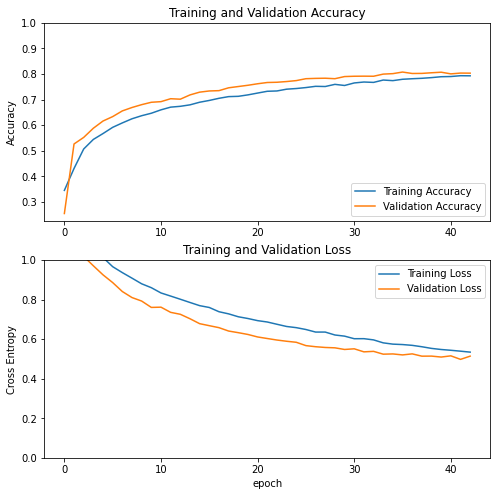

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# get validation dataset labels
val_labels = np.concatenate([y for x,y in val_ds],axis=0)
val_labels_count = Counter(val_labels)
val_labels_count


Counter({0: 817, 1: 815, 2: 812, 3: 788})

In [ ]:
# predict validation set labels
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = model.predict(val_ds)
pred_per = probability_model.predict(val_ds)
max = np.argmax(predictions,axis=1)



In [ ]:
print(val_labels.shape)
print(predictions)

(3232,)
[[-0.95222765 -3.8968153   3.4277463   4.245586  ]
 [ 0.24236071 -5.67847     3.3992996   3.3874846 ]
 [-1.9875932   4.476082   -0.37768415 -0.43741894]
 ...
 [ 7.8398924  -4.075383   -3.6932886   1.0095848 ]
 [ 2.1344328  -2.2914162  -1.9152699   3.6867142 ]
 [ 8.126129   -4.9618287  -3.2204175   1.027964  ]]


In [ ]:
# confusion matrix for validation data
cf_a = tf.math.confusion_matrix(
    val_labels, max, num_classes=4, weights=None, dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
# function for confusion matrix plotting

def plot_confusion_matrix(cm, class_names,title="Confusion Matrix"):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  
  figure,ax = plt.subplots(figsize=(8, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar(im,ax=ax)
  ax.set_aspect('auto')
  plt.title(title)
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

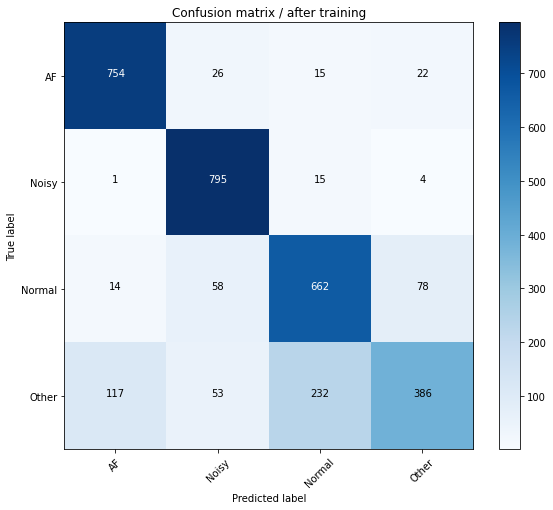

In [ ]:
# plot the confusion matrix
cf_fig_a = plot_confusion_matrix(cf_a.numpy(),class_names_v, "Confusion matrix / after training")
cf_fig_a.show()

In [ ]:
def plot_multiclass_roc(X_test, y_test, label, n_classes, figsize=(17, 6)):
    y_score = probability_model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],label[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()



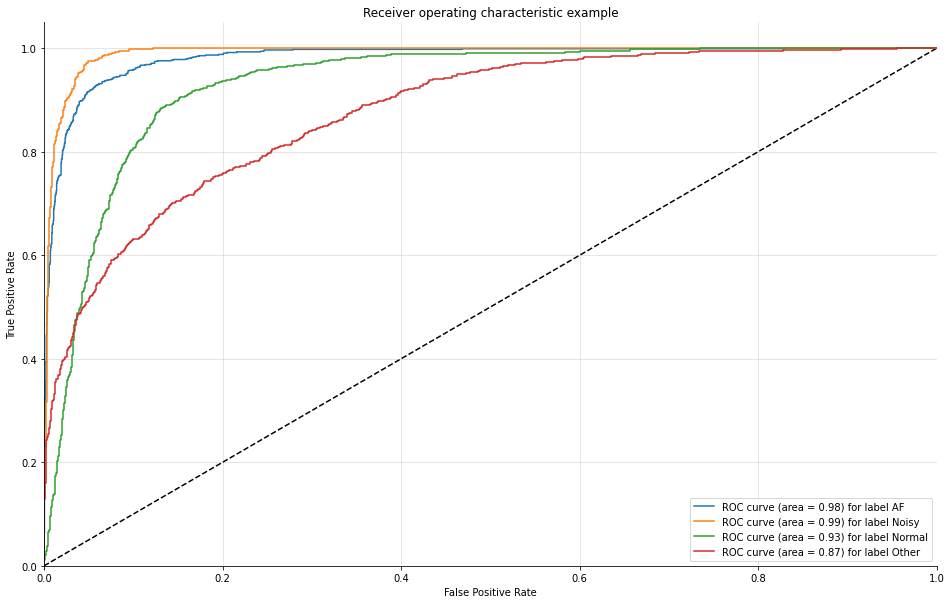

In [ ]:
# plot ROC curves
plot_multiclass_roc(val_ds, val_labels, class_names_v, n_classes=4, figsize=(16, 10))

In [ ]:
# classification reports
print(classification_report(val_labels, max, target_names=class_names_v))

              precision    recall  f1-score   support

          AF       0.85      0.92      0.89       817
       Noisy       0.85      0.98      0.91       815
      Normal       0.72      0.82      0.76       812
       Other       0.79      0.49      0.60       788

    accuracy                           0.80      3232
   macro avg       0.80      0.80      0.79      3232
weighted avg       0.80      0.80      0.79      3232



## Visualize convolution filters

In [ ]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (5, 5, 32, 64)
conv2d_2 (9, 9, 64, 128)


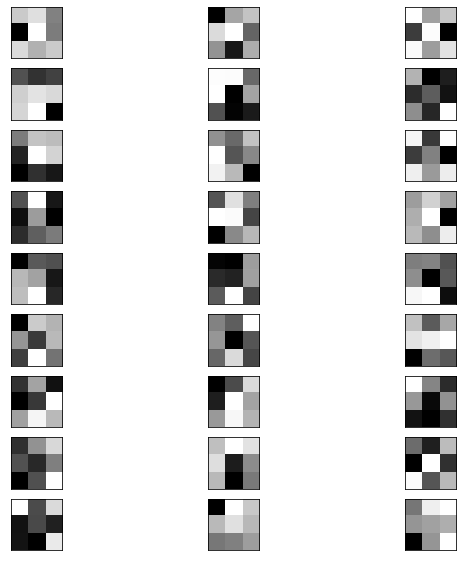

In [ ]:
# retrieve weights from the first convolution layer
filters, biases = model.layers[3].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 9, 1

# create a new figure
plt.figure(figsize=(10, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

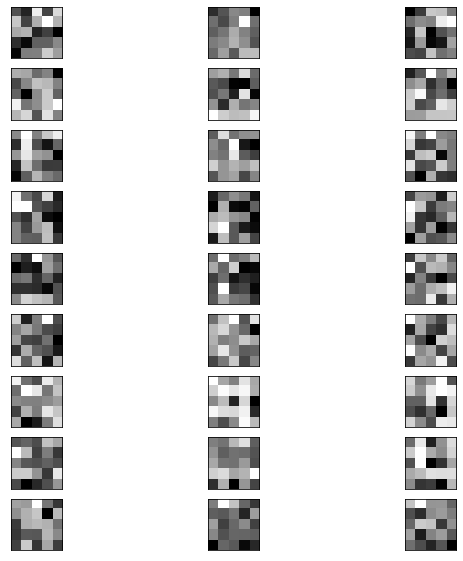

In [ ]:
# retrieve weights from the second convolution layer
filters, biases = model.layers[7].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 9, 1

# create a new figure
plt.figure(figsize=(10, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

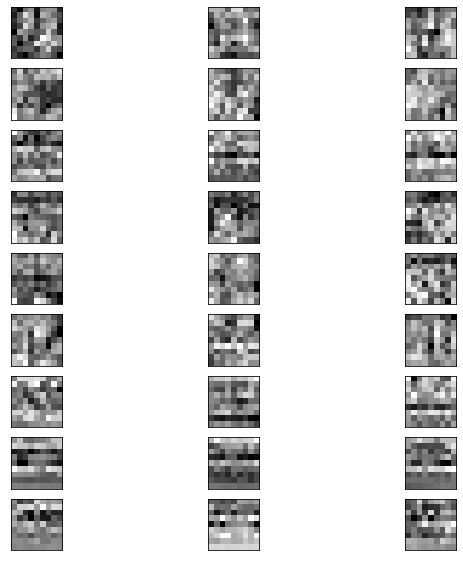

In [ ]:
# retrieve weights from the third convolution layer
filters, biases = model.layers[11].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 9, 1

# create a new figure
plt.figure(figsize=(10, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
model.layers
